# Tutorial3: 图像分类2

本节旨在展示更接近实际的训练场景，使用ResNet50训练ImageNet数据集，在多块显卡上做并行。

分以下几步来实现：
1. 环境安装
2. 分步运行本文件

    2.1 数据加载和预处理

    2.2 模型

    2.3 训练与评估

    2.4 加载模型


ImageNet 是一个大型的视觉数据库，由斯坦福大学的李飞飞（Fei-Fei Li）教授及其团队于2009年创建。ImageNet包含了1000个类别总计120万张训练图片，以及5万张验证图片。用户需从 ImageNet 官网自行下载 ImageNet 数据集：https://image-net.org

## 1. 环境安装

## 1. 环境安装

我们默认用户已经按照 [tutorial_scow_for_ai](../tutorial_scow_for_ai.md) 在 “交互式应用” 中创建了  Jupyter Lab 应用，并已经安装了 conda。现在需要在命令行中创建环境并注册 ipykernal：

```bash
conda create -n tutorial3 python=3.9
conda activate tutorial3
# 安装内核
conda install ipykernel
# 注册内核
python -m ipykernel install --usetutorial3tutorial1 --displtutorial3tutorial1

pip install numpy==1.26.4 matplotlib==3.8.4
conda install pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia==1.5.0

# 查看已注册的内核
jupyter kernelspec list
```

（ pytorch 版本需与 cuda 版本对应，请查看版本对应网站：https://pytorch.org/get-started/previous-versions ，通过 nvidia-smi 命令可查看 cuda 版本）

选择本 ipynb 的 kernel 为 tutorial3， 硬件资源为2个GPU。

CUDA Version: 12.1; Torch Version: 2.3.1

## 2. 分步运行本文件

### 2.1 数据预处理

In [1]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# 数据预处理
train_transforms = transforms.Compose([
    transforms.Resize(40), # 放大到40像素
    transforms.RandomResizedCrop(32, scale=(0.64, 1.0), ratio=(1.0, 1.0)), # 裁剪
    transforms.RandomHorizontalFlip(), # 随机水平翻转
    transforms.RandomRotation(10),  # 随机旋转 10 度
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]) # 标准化
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

# 加载训练集和测试集
# VAR_PLACEHOLDER
train_dataset = datasets.CIFAR10(root='./cifa', train=True, download=True, transform=train_transforms)
val_dataset = datasets.CIFAR10(root='./cifar', train=False, download=True, transform=train_transforms)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/home/cly/miniconda3/envs/tutorial3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/cly/miniconda3/envs/tutorial3/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/cly/miniconda3/envs/tutorial3/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/cly/miniconda3/envs/tutorial3/lib/python3.9/site-packages/traitlets/config/application.py", line 10

Files already downloaded and verified
Files already downloaded and verified


### 2.2 模型

ResNet 是由何凯明于 2015 年提出的网络结构，ResNet结构使得网络的层数能够做得更深，对之后的工作有深远的影响。这里我们使用的是PyTorch自带的ResNet-50模型。

In [2]:
import torch
import torchvision.models as models

# 加载未经过预训练的 ResNet-50 模型
model = models.resnet50() # 不使用预训练权重

### 2.3 训练与评估

我们需要在多卡上并行训练，这里我们使用的是两张A100显卡。

在训练过程中我们增加了学习率调整策略，以加速收敛。

完成模型训练和评估需要约 13 h

下面版本的代码只能在 GPU 上跑，请申请相应的资源并指定使用的 GPU 数量。

这里还实现了一些常用的函数和类，可用于计时和绘图等。

In [3]:
# 常用函数和类实现

# 评估函数
def accuracy(model, data_loader, devices, topk=(1, )):
    model.eval()
    total = 0
    correct = {k: 0 for k in topk}

    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(devices[0]), y.to(devices[0])
            outputs = model(X)

            _, predicted = outputs.topk(max(topk), dim=1, largest=True, sorted=True)
            correct_k = (predicted == y.view(-1, 1).expand_as(predicted))

            total += y.size(0)
            for k in topk:
                correct[k] += correct_k[:, :k].float().sum().item()

    return  {f'top-{k}': 100 * correct[k] / total for k in topk}


# 训练函数
def train(model, train_loader, loss, optimizer, devices):
    model.train()

    loss_list = []
    time_load = log_time()
    time_train = log_time()

    data_iter = iter(train_loader)
    count = 0
    while True:
        # 加载数据
        try:
            time_load.start()
            X, y = next(data_iter)
            X, y = X.to(devices[0]), y.to(devices[0])
            time_load.stop()
            count += 1
        except StopIteration:
            break
       
        # 训练
        time_train.start()
        outputs = model(X)
        l = loss(outputs, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        time_train.stop()

        # loss 记录
        loss_list.append(l.item())
        
        # 输出 注意：在 GPU 上使用逻辑语句非常耗时，如果不关心 epoch 中间的训练过程，请注释掉这部分
        if (count > 0) and (count % 1000 == 0):
            average_load_time = sum(time_load.times[-1000:]) / 1000
            average_train_time = sum(time_train.times[-1000:]) / 1000
            average_loss = sum(loss_list[-1000:]) / 1000
            print(f"batch: {count} | batch loss: {average_loss} | batch load time: {average_load_time} | batch train time: {average_train_time}")

    average_loss = sum(loss_list) / len(loss_list)

    return average_loss, time_load.sum(), time_train.sum()


# 计时器
import time
from datetime import timedelta

class log_time():
    """记录运行过程的时间片段"""
    def __init__(self):
        self.times = []
        self.beg = None
        self.end = None

    def start(self):
        # 开始计时
        self.beg = time.time()

    def stop(self):
        # 停止计时
        self.end = time.time()
        self.times.append(self.end - self.beg)

    def avg(self):
        # 平均时长
        return sum(self.times) / len(self.times)

    def sum(self):
        # 总时长
        return sum(self.times)

# 过程记录和绘图
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
from IPython import display

class log_process:
    """在训练过程中动态绘制数据"""
    def __init__(self, epochs, figsize=(4, 3)):
        backend_inline.set_matplotlib_formats('svg')
        self.epochs = epochs
        self.fig, self.ax1 = plt.subplots(figsize=figsize)
        self.ax2 = self.ax1.twinx()
        self.epochs = epochs
        self.train_ls = []
        self.test_acc = []

    def update(self, epoch, average_loss, test_acc):
        """向图表中添加数据点并更新图表"""
        self.train_ls.append(average_loss)
        self.test_acc.append(test_acc)
        
        # 清除当前轴的内容

        self.ax1.cla()  
        self.ax2.cla()

        # 绘制损失
        self.ax1.plot(list(range(1, epoch + 2)), self.train_ls, 'b-', label='train Loss')
        self.ax1.set_xlabel('Epoch')
        self.ax1.set_ylabel('Train Loss', color='b')
        self.ax1.tick_params(axis='y', labelcolor='b')
        #self.ax1.set_yscale('log')
        self.ax1.set_xlim([1, self.epochs])

        # 绘制准确率
        self.ax2.plot(list(range(1, epoch + 2)), self.test_acc, 'r--', label='test accuracy')
        #self.ax2.set_ylabel('Test Accuracy (%)', color='r')
        self.ax2.tick_params(axis='y', labelcolor='r')
        self.fig.legend(loc='upper right')

        display.display(self.fig)
        display.clear_output(wait=True)

训练过程

In [ ]:
# 训练过程

from torch.utils.data import DataLoader
import torch.nn as nn
import torch_npu
import os
import acl

# 参数设置
epochs, batch_size, npu_n = 20, 256, 2
learning_rate, momentum, weight_decay = 0.1, 0.9, 1e-4
topk = (1, 5)
show_top_k = 5

# 指定NPU设备
device = torch.device('npu:0') if torch.npu.is_available() else torch.device('cpu')

# 加载模型
model.to(device)
    
# 损失函数
loss_fn = nn.CrossEntropyLoss().to(device)

# 优化器
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

# 学习率调整策略
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

# 数据准备
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True)

# 主训练循环
train_ls = []
train_time = []
load_time = []
val_time = log_time()
train_process = log_process(epochs, figsize=(4, 3))
for epoch in range(epochs):
    
    # 训练
    batch_average_loss, epoch_load_time, epoch_train_time = train(model, train_loader, loss, optimizer, devices)
    train_ls.append(batch_average_loss/batch_size)
    load_time.append(epoch_load_time)
    train_time.append(epoch_train_time)

    # 验证
    val_time.start()
    accuracy_dict = accuracy(model, val_loader, device, topk=topk)
    val_time.stop()

    # 调整学习率
    scheduler.step()

    # 更新和输出
    average_loss = sum(train_ls)/len(train_ls)
    average_load_time = timedelta(seconds=sum(load_time)/len(load_time))
    average_train_time = timedelta(seconds=sum(train_time)/len(train_time))
    average_val_time = timedelta(seconds=val_time.avg())
    print(f"loss: {average_loss} | test accuracy: {accuracy_dict} | load_time: {average_load_time} | train_time: {average_train_time} |  val_time: {average_val_time}")
    
    train_process.update(epoch, average_loss, accuracy_dict[f'top-{show_top_k}'])

    # 保存模型
    os.makedirs('./modles', exist_ok=True)
    torch.save(model.state_dict(), f'./modles/resnet50_epoch_{epoch+1}.pth')

RuntimeError: Initialize:build/CMakeFiles/torch_npu.dir/compiler_depend.ts:217 NPU function error: at_npu::native::AclSetCompileopt(aclCompileOpt::ACL_PRECISION_MODE, precision_mode), error code is 500001
[ERROR] 2024-11-12-23:48:37 (PID:34719, Device:0, RankID:-1) ERR00100 PTA call acl api failed
[Error]: The internal ACL of the system is incorrect.
        Rectify the fault based on the error information in the ascend log.


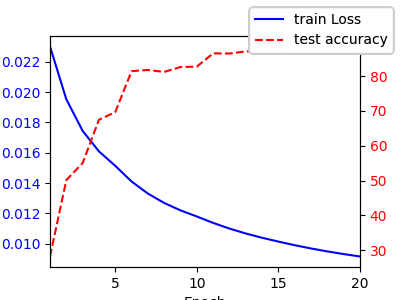

### 2.4 加载模型

之后可以加载模型参数重复使用模型训练的结果

In [ ]:
import torch
import torchvision.models as models

# 先确保有一个与之前保存权重相匹配的模型架构
model = models.resnet50(pretrained=False)

# 加载之前保存的权重
state_dict = torch.load(f'./modles/resnet50_epoch_{epoch+1}.pth')
model.load_state_dict({k.replace('module.',''):v for k,v in state_dict.items()})

---

> 作者: 黎颖; 龙汀汀
>
> 联系方式: yingliclaire@pku.edu.cn;   l.tingting@pku.edu.cn